# Experimentos
En general se quiere probar que
1- Los algoritmos permiten aprender

2- Los algoritmos generalizan

3- Los algoritmos entrenan mas rápido que la wea cruda (Estabilidad, velocidad)

5- Cuanto depende del dataset ese aprendizaje

4- Son capaces de aprender de alguna distribución generada en la vecindad del dataset

6- Permiten una mejor estabilidad frente al ruido que el entrenamiento en crudo (En que momento pasa el umbral de tanto x)

7- Feats permiten una mejor estabilidad frente al ruido que el uso de logits solo

8- Funcionamiento de feats > funcionamiento de KD > funcionamiento de CE solo


Por cada experimento interesa

1- velocidad de convergencia (estabilidad?) (En que epoca el algoritmo pasa 3 epochs sin crecer)

2- Acc en test 

3- Acc en test / train

4- Mejores y peores

5- Delta sobre KD, CE

6- grafico que permita ver tendencia según tecnica/capa

7- media de feats por capa

Los experimentos disponibles sobre Cifar 10 son

| Experimento    | ce | kd | feat |   |
|----------------|----|----|------|---|
| Dataset Normal | x  | x  | x    |   |
| Ruido  (0,1-1) |    | x  | x    |   |
| GAN            |    | x  | x    |   |
| VAE            |    | x  | x    |   |

Podria faltar grid de ruido con temperatura
Podría ser interesante probar con alguna medida de distancia entre y_t y y_s, implica correr todo de nuevo

### Carga de datos

In [185]:
import pandas as pd
import altair as alt

global_titles={ "test_acc":"Accuracy en validacion",
                "test_teacher/acc":"Accuracy de red tutora en validacion",
                "test_loss":"Perdida en entrenamiento",
                "test_eval":"Evalucacion en entrenamiento",
                "train_acc":"Accuracy en entrenamiento",
                "train_teacher/acc":"Accuracy de red tutora en entrenamiento",
                "train_loss":"Perdida en entrenamiento",
                "train_eval":"Evaluacion en entrenamiento",
                "student":"Modelo",
                "model":"Modelo",
                "layer":"Bloque",
                "transform":"Transformacion",
                "dataset":"Base de datos",
                "temp":"Temperatura (log)",
                "log_dist":"Perdida en logits",
                "feat_dist":"Perdida en features",
                "delta_test":"Diferencia con red tutora en entrenamiento",
                "test/train":"Ratio de accuracy en entreamiento y validacion",
                "noise":"Potencia de Ruido"
                }

CE_path=["Cifar10/%s/record.json"%model for model in ["ResNet101","ResNet18","MobileNet"]]

import json
def load_teachers(CE_path):
    def flatten_record(path):
        i=json.load(open(path,'r'))
        d={}
        for k,v in i.items():
            if isinstance(v, dict) :
                for l in v.values():
                    for ki,vi in l.items():
                        #print(l.values())
                        d["_".join([k,ki])]=vi
            else:
                d[k]=v
        return d

    d={'model':[],
     'test_acc': [],
     'test_loss ': [],
     'train_acc': [],
     'train_loss ': [],
     'epoch': [],
     'train_step': [],
     'test_step': []}

    for path in CE_path:
        d['model'].append(path.split("/")[-2])
        for k,v in flatten_record(path).items():
            d[k].append(v)
    return pd.DataFrame.from_dict(d)

data={}
data['teachers']=load_teachers(CE_path)
data["students"]={'feat':{},
                  'kd':{}}

drop_cols=['Unnamed: 0', 'epoch','lr', 'resume', 'epochs', 'train_batch_size', 'test_batch_size','batch_size','teacher', 'exp_name','student_layer', 'teacher_layer','distillation','pre']

import glob
paths=glob.glob("Cifar10/**/summary.csv",recursive=True)
#print(paths)
for path in paths:
    ks=path.split("/")[-2].split("_")
    da=pd.read_csv(path)
    
    cols=[i for i in da if i in drop_cols]
    
    if ks[0]=='kd':
        da['temp']=[int(i.split('-')[-1]) for i in da['distillation']]
        da['log_dist']=[i.split(',')[0] for i in da['distillation']]
        da['feat_dist']='Ninguna'
        da['layer']='Ninguna'
    elif ks[0]=='feat':
        
        da['temp']=[int(i.split('-')[-1]) if len(i.split('-')) > 1 else 8 for i in da['last_layer'] ]
        da['log_dist']=[i.split(',')[0] for i in da['last_layer']]
        da['feat_dist']=da['distillation']
        
    da['transform']=['Ninguna' if i=='none,' else i for i in da['transform'] ]
    da['delta_test']=[i-data["teachers"].at[0,'test_acc'] for i in da['test_acc']]
    da['test/train']=da['test_acc']/da["train_acc"]
    da['noise']=[float(i.split(",")[1]) if i!="Ninguna" else 0.0 for i in da['transform']]
    da.index=pd.Index([",".join([str(i) for i in [row["student"],row["dataset"],row["log_dist"],row["feat_dist"],row["layer"],row["noise"]]]) for i,row in da.iterrows()])
    
    
    data["students"][ks[0]]['KD' if ks[1]=='normal' else ks[1]]=da.drop(cols, axis=1)
    
data["students"]['kd']['GAN']


,test_acc,test_teacher/acc,test_loss,test_eval,train_acc,train_teacher/acc,train_loss,train_eval,student,transform,dataset,temp,log_dist,feat_dist,layer,delta_test,test/train,noise
"MobileNet,GAN,KD,Ninguna,Ninguna,0.0",23.07,93.94,0.147525,5.779560,3.023,3.007,0.000903,15.865241,MobileNet,Ninguna,GAN,8,KD,Ninguna,Ninguna,-70.87,7.631492,0.0
"ResNet18,GAN,KD,Ninguna,Ninguna,0.0",37.72,93.94,0.124460,6.134784,3.037,3.070,0.000448,15.967446,ResNet18,Ninguna,GAN,8,KD,Ninguna,Ninguna,-56.22,12.420151,0.0


In [142]:
data["students"]['feat']['noise']

,test_acc,test_teacher/acc,test_loss,test_eval,train_acc,train_teacher/acc,train_loss,train_eval,student,last_layer,layer,transform,dataset,temp,log_dist,feat_dist,delta_test,test/train,noise
"MobileNet,cifar10,,KD,att_max,0,0.1",87.16,93.94,0.019017,1.077897,88.150,90.648,0.008877,0.831166,MobileNet,"KD,T-8",0,"noise,0.1","cifar10,",8,KD,att_max,-6.78,0.988769,0.1
"MobileNet,cifar10,,KD,att_max,1,0.1",87.61,93.94,0.018349,1.028444,88.272,90.654,0.008999,0.816178,MobileNet,"KD,T-8",1,"noise,0.1","cifar10,",8,KD,att_max,-6.33,0.992500,0.1
"MobileNet,cifar10,,KD,att_max,2,0.1",87.10,93.94,0.019883,1.067656,88.142,90.630,0.009189,0.838657,MobileNet,"KD,T-8",2,"noise,0.1","cifar10,",8,KD,att_max,-6.84,0.988178,0.1
"MobileNet,cifar10,,KD,att_max,3,0.1",87.46,93.94,0.023735,1.049526,88.240,90.682,0.012695,0.822420,MobileNet,"KD,T-8",3,"noise,0.1","cifar10,",8,KD,att_max,-6.48,0.991160,0.1
"MobileNet,cifar10,,KD,att_mean,0,0.1",86.76,93.94,0.020558,1.102234,88.202,90.622,0.008982,0.822932,MobileNet,"KD,T-8",0,"noise,0.1","cifar10,",8,KD,att_mean,-7.18,0.983651,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"ResNet18,cifar10,,KD,nst_linear,3,1.0",23.46,93.94,0.201055,8.428604,10.010,10.006,0.001312,38.780303,ResNet18,"KD,T-8",3,"noise,1.0","cifar10,",8,KD,nst_linear,-70.48,2.343656,1.0
"ResNet18,cifar10,,KD,PKT,0,1.0",13.06,93.94,0.187323,10.875332,10.002,10.006,0.000226,38.746196,ResNet18,"KD,T-8",0,"noise,1.0","cifar10,",8,KD,PKT,-80.88,1.305739,1.0
"ResNet18,cifar10,,KD,PKT,1,1.0",10.15,93.94,0.254730,20.034712,10.006,10.014,0.000232,38.742675,ResNet18,"KD,T-8",1,"noise,1.0","cifar10,",8,KD,PKT,-83.79,1.014391,1.0
"ResNet18,cifar10,,KD,PKT,2,1.0",10.91,93.94,0.255839,18.802161,10.012,10.018,0.000232,38.735743,ResNet18,"KD,T-8",2,"noise,1.0","cifar10,",8,KD,PKT,-83.03,1.089692,1.0


In [6]:
data["students"]['no_feats']=data["teachers"][data["teachers"]['model']!="ResNet101"]
bar_source=data["students"]['no_feats']

In [141]:
bar_source['delta_test']=[i-data["teachers"].at[0,'test_acc'] for i in bar_source['test_acc']]
bar_source['test/train']=bar_source['test_acc']/bar_source["train_acc"]

bar_source['dist']='CE'
bar_source

,model,test_acc,test_loss,train_acc,train_loss,epoch,train_step,test_step,delta_test,test/train,dist,wea
1,ResNet18,93.34,0.533314,99.846,0.004576,400,156400,40000,-0.6,0.93484,CE,1.0
2,MobileNet,89.94,0.580561,99.544,0.013739,400,156400,40000,-4.0,0.90352,CE,NaN


In [163]:
['test_teacher/acc',
 'test_eval',
 'train_teacher/acc',
 'train_eval',
 'transform',
 'dataset',
 'temp',
 'delta_test',
 'test/train',
 'last_layer']

bar_source['student']=bar_source['model']
bar_source['log_dist']='CE'
bar_source['feat_dist']='Ninguna'
bar_source['layer']='Ninguna'
bar_source

/home/jpruiz/anaconda3/envs/Memoria1/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jpruiz/anaconda3/envs/Memoria1/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/jpruiz/anaconda3/envs/Memoria1/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,model,test_acc,test_loss,train_acc,train_loss,epoch,train_step,test_step,delta_test,test/train,dist,student,log_dist,feat_dist,layer
1,ResNet18,93.34,0.533314,99.846,0.004576,400,156400,40000,-0.6,0.93484,CE,ResNet18,CE,Ninguna,Ninguna
2,MobileNet,89.94,0.580561,99.544,0.013739,400,156400,40000,-4.0,0.90352,CE,MobileNet,CE,Ninguna,Ninguna


['Unnamed: 0',
 'epoch',
 'lr',
 'resume',
 'epochs',
 'train_batch_size',
 'test_batch_size',
 'teacher',
 'exp_name']

In [ ]:
bar_source=data["students"]['no_feats']

## Graficos Dataset Normal

### Tabla teachers, (mejores, peores, media) en KD y con feats

### Valores de KD contra temperatura

In [390]:
source=data['students']['kd']['KD']
title="Diferencia de accuracy en entrenamiento con respecto a Resnet101."
y="delta_test"
x="temp"
color='student'
shape='log_dist'

chart=alt.Chart(source,title=title).mark_point(size=100).encode(
        alt.Y(y, type='quantitative',title=global_titles[y],scale=alt.Scale(zero=False,base=10,type='linear')),
        alt.X(x, type='quantitative',title=global_titles[x],scale=alt.Scale(zero=False,base=10,type='log')),
        color=alt.Color(color, legend=alt.Legend(title=global_titles[color])),
        shape=alt.Shape(shape, legend=alt.Legend(title=global_titles[shape])),
        #size=50
    ).interactive()

bar=alt.Chart(bar_source).mark_rule(opacity=0.5).encode(
                    y=y,
                    color=alt.Color('model', legend=alt.Legend(title="Modelo")),
                    stroke=alt.Stroke('model', legend=alt.Legend(title="Modelo en Cross Entropy")),
                    size=alt.value(2))
d=bar+chart
d.properties(width=600,height=600).configure_axis(titleFontSize=12).configure_title(fontSize=15)


alt.LayerChart(...)

In [409]:

def grafico_con_barra_xy_CE(source=data['students']['kd']['KD'],
                        title="Ratio entre accuracy en validacion y accuracy en entrenamiento.",
                        y="test/train",
                        x="temp",
                        color='student',
                        shape='log_dist'):

    chart=alt.Chart(source,title=title).mark_point(size=100).encode(
            alt.Y(y, type='quantitative',title=global_titles[y],scale=alt.Scale(zero=False,base=10,type='linear')),
            alt.X(x, type='quantitative',title=global_titles[x],scale=alt.Scale(zero=False,base=10,type='log')),
            color=alt.Color(color, legend=alt.Legend(title=global_titles[color])),
            shape=alt.Shape(shape, legend=alt.Legend(title=global_titles[shape])),
            #size=50
        ).interactive()

    bar=alt.Chart(bar_source).mark_rule(opacity=0.5).encode(
                        y=y,
                        color=alt.Color('model', legend=alt.Legend(title="Modelo")),
                        stroke=alt.Stroke('model', legend=alt.Legend(title="Modelo en Cross Entropy")),
                        size=alt.value(2))
    d=bar+chart
    d.properties(width=600,height=600).configure_axis(titleFontSize=12).configure_title(fontSize=15)
    
    return d
grafico_con_barra().properties(width=600,height=600)

alt.LayerChart(...)

### Valores usando features con KD
test_acc,*feats(layer), raya en logit (t8), en grid ([kd,ce,kdce] [mobilenet,resnet])

In [80]:
data['students']['feat'].keys()

dict_keys(['VAE', 'normal', 'CE', 'GAN', 'noise'])

In [401]:
def normal_whole_source(key):
    if key == 'CE':
        source=data['students']['feat']['CE']
        source=pd.concat([bar_source,source])
        return source
    
    d=data['students']['kd'][key]
    d=d[d["temp"]==8]
    d=d[d["log_dist"]==key]
    source=data['students']['feat'][key]
    source=pd.concat([d,source])
    return source
        
source=normal_whole_source('KD')

In [407]:

def grafico_con_columnas(source,
                         y='test_acc',
                         title="Accuracy en validacion desacoplado segun destilacion",
                         shape='student',
                         column='feat_dist',
                         color='layer',
                         fill=None
                        ):
    encodings={"shape":alt.Shape("%s:O"%shape,legend=alt.Legend(title=global_titles[shape])),
        "y":alt.Y(y,title=global_titles[y]),
        "column":alt.Column('%s:O'%column,title=global_titles[column]),
        "x":alt.X('%s:N'%color,title=global_titles[color]),
        "color":alt.Color('%s:N'%color,legend=alt.Legend(title=global_titles[color]))}
    
    if fill is not None:
        encodings["fill"]=alt.Color(fill)

    d1=alt.Chart(source,title=title).mark_point(size=100).encode(**encodings
        ).configure_axis(titleFontSize=12,labelFontSize=12).configure_title(fontSize=15).interactive()
    return d1.properties(width=70,height=600)

grafico_con_columnas(source)

alt.Chart(...)

In [408]:

grafico_con_columnas(source,y='test/train',title="Ratio  accuracy en validacion con accuracy en entrenamiento.")

alt.Chart(...)

3- Barras con test_acc/train_acc*feats(layer), raya en logit (t8), en grid ([kd,ce,kdce] [mobilenet,resnet])

In [427]:

def grafico_con_barra_y_CE(source=source,
                        title="Diferencia de accuracy en entrenamiento con respecto a Resnet101.",
                        y="delta_test",
                        x="feat_dist",
                        fill='layer',
                        color='student',
                        shape='layer'):
    
    chart=alt.Chart(source,title=title).mark_point(size=150).encode(
           
            y=alt.Y(y, type='quantitative',title=global_titles[y],
                    scale=alt.Scale(zero=False,base=10,type='linear')),
            x=alt.X(x, title=global_titles[x]),
            color=alt.Color(color, legend=alt.Legend(title=global_titles[color])),
            fill=alt.Fill('%s:O'%fill, legend=alt.Legend(title=global_titles[fill]), scale=alt.Scale(scheme='darkgreen')),
            shape=alt.Shape("%s:O"%shape,legend=alt.Legend(title=global_titles[shape])),
        )


    bar=alt.Chart(bar_source).mark_rule(opacity=0.5).encode(
                        y=y,
                        color=alt.Color('model', legend=alt.Legend(title="Modelo")),
                        stroke=alt.Stroke('model', legend=alt.Legend(title="Modelo en Cross Entropy")),
                        size=alt.value(2))
    d=bar+chart
    d.properties(width=600,height=600).configure_axis(titleFontSize=12).configure_title(fontSize=15)
    
    return d

grafico_con_barra_y_CE().properties(width=600,height=600)

alt.LayerChart(...)

### COn todo si no pa shrek

In [430]:
s1=normal_whole_source('CE')
s2=normal_whole_source('KD')
source=pd.concat([s1,s2])

In [438]:


grafico_con_columnas(source,fill='log_dist')

alt.Chart(...)

In [444]:
grafico_con_columnas(source,
                     y='test/train',
                     title="Ratio  accuracy en validacion con accuracy en entrenamiento.",
                     shape='student',
                     column='feat_dist',
                     color='layer',
                     fill='log_dist')

alt.Chart(...)

3- Barras con test_acc/train_acc*feats(layer), raya en logit (t8), en grid ([kd,ce,kdce] [mobilenet,resnet])

In [447]:

grafico_con_barra_y_CE(shape='log_dist').properties(width=600,height=600)

alt.LayerChart(...)

### Tiempos de convergencia
4- majamama tiempo de convergencia, acc (epochs y tiempo)

In [154]:
import json

d=json.load(open('Cifar10/epoch_summary.json','r'))
def exp_parse(split):
        split=k.split("/")
        exp=split[2]
        exp_type="feat"
        if len(exp.split("_"))>1:
            if exp.split("_")[0].lower()=='kd':
                exp_type="kd"
        
        if exp_type=="kd":
            dataset=exp.split("_")[1]
        elif len(exp.split("_"))==1:
            dataset=exp
        elif exp.split("_")[0]=="feat":
            dataset=exp.split("_")[1]
        else:
            dataset=exp.split("_")[0]
        if dataset=='normal':
            dataset='KD'
               
        if dataset=="noise":
            #transform=
            #['Cifar10', 'ResNet101', 'noise', '0.1', 'MobileNet', 'att_max', '0', '', '']
            noise=float(split[3])
            model=split[4]
            if exp_type=='kd':
                temp=int(split[6].split("-")[-1])
                logit_loss=split[5]            
                #print(model,logit_loss,dataset, temp,noise)
            else:
                layer=int(split[6])
                feat_loss=split[5]            
                #print(model,feat_loss,dataset, layer,noise)
        else:
            noise=0.0
            model=split[3]
            if exp_type=='kd':
                temp=int(split[5].split("-")[-1])
                logit_loss=split[4]       
            else:
                layer=int(split[5])
                feat_loss=split[4]    
                
        if exp_type=='kd':
            feat_loss="Ninguna"
            layer="Ninguna"
        else:
            logit_loss=dataset if dataset not in ['GAN','VAE','noise'] else 'KD'
        key2=dataset
        dataset=dataset if dataset in ['GAN','VAE'] else"cifar10,"
                
        return model, exp_type,logit_loss,feat_loss,key2, layer,noise,dataset

In [179]:
conv_data={}
conv_data['teachers']={'loss_conv':[],'acc_conv':[],'index':[],'max':[],'t':[]}#load_teachers(CE_path)
conv_data["students"]={'feat':dict([(k,{'loss_conv':[],'acc_conv':[],'index':[],'max':[],'t':[]}) for k in list(data['students']['feat'].keys() )]),
                       'kd':dict([(k,{'loss_conv':[],'acc_conv':[],'index':[],'max':[],'t':[]}) for k in list(data['students']['kd'].keys() )])}


def convergencia(s,neg=True):
    j=[s[i]-s[i-1] for i in range(1,len(s))]
    p=3
    for n,i in enumerate(j):
        if (i>0) ==neg:
            p-=1
        else:
            p=3
            
        if p<0:
            return n-2

for k,v in d.items():
    split=k.split("/")
    teacher=split[1]
    exp=split[2]
    #print(exp)
    if exp=='teacher':
        #teacher_dict[teacher]=v
        conv_data['teachers']['index'].append(key)
        conv_data['teachers']['loss_conv'].append(np.argmin(v["train/loss_"]))
        conv_data['teachers']['acc_conv'].append(np.argmax(v["test/acc"]))
        conv_data['teachers']['max'].append(np.max(v["test/acc"]))
        conv_data['teachers']['t'].append(k)
    else:
        model, exp_type,logit_loss,feat_loss,key2, layer,noise,dataset=exp_parse(k) #(FALTA UNA KEY
        
        key=','.join([str(i) for i in [model,dataset,logit_loss,feat_loss,layer,noise]])
        
        conv_data['students'][exp_type][key2]['index'].append(key)
        conv_data['students'][exp_type][key2]['loss_conv'].append(np.argmin(v["train/loss"]))
        conv_data['students'][exp_type][key2]['acc_conv'].append(np.argmax(v["test/acc"]))
        conv_data['students'][exp_type][key2]['max'].append(np.max(v["test/acc"]))
        conv_data['students'][exp_type][key2]['t'].append(k)
        #print(k,key,"  ",exp_type,key2)
    #hacer pandas con summarys de dict, argmax de test acc y convergencia
    


In [183]:
conv_data['students']['feat']['KD']

{'loss_conv': [49,
  48,
  49,
  48,
  49,
  49,
  49,
  49,
  48,
  49,
  26,
  47,
  49,
  49,
  49,
  48,
  46,
  49,
  41,
  49,
  49,
  49,
  48,
  48,
  49,
  48,
  49,
  47,
  48,
  48,
  49,
  49,
  49,
  49,
  49,
  42,
  49,
  49,
  49,
  49,
  49,
  48,
  47,
  47,
  48,
  48,
  49,
  49],
 'acc_conv': [46,
  46,
  48,
  48,
  44,
  44,
  46,
  49,
  49,
  47,
  46,
  4,
  48,
  48,
  45,
  49,
  45,
  47,
  46,
  49,
  37,
  49,
  46,
  49,
  42,
  49,
  40,
  47,
  44,
  44,
  46,
  49,
  36,
  43,
  45,
  44,
  40,
  48,
  49,
  46,
  47,
  44,
  45,
  46,
  45,
  48,
  49,
  41],
 'index': ['MobileNet,cifar10,,KD,att_max,0,0.0',
  'MobileNet,cifar10,,KD,att_max,1,0.0',
  'MobileNet,cifar10,,KD,att_max,2,0.0',
  'MobileNet,cifar10,,KD,att_max,3,0.0',
  'MobileNet,cifar10,,KD,att_mean,0,0.0',
  'MobileNet,cifar10,,KD,att_mean,1,0.0',
  'MobileNet,cifar10,,KD,att_mean,2,0.0',
  'MobileNet,cifar10,,KD,att_mean,3,0.0',
  'MobileNet,cifar10,,KD,hint,0,0.0',
  'MobileNet,cifar1

In [178]:
# Graficos de tiempo
def d2plambda( dic,model):
    #for k,i in dic.items():
    #    dic[k]=[0]
        
    df=pd.DataFrame.from_dict(dic)
    df['model']=model
    df['epochs']=range(1,len(df['model'])+1)
    #df
    return df

source=pd.concat([d2plambda(v,k) for k,v in teacher_dict.items()])
source

,train/acc,train/loss_,train/wall_time,test/acc,test/loss_,test/wall_time,model,epochs
0,21.769621,2.086376,12.283142,46.069268,1.469116,0.783901,MobileNet,1
1,40.927195,1.597387,39.280290,49.830773,1.395166,26.461292,MobileNet,2
2,49.144636,1.400927,59.088391,58.753750,1.159509,52.189522,MobileNet,3
3,55.997007,1.221943,89.555959,63.340387,1.042309,77.735241,MobileNet,4
4,61.810993,1.065347,116.744323,68.763209,0.892054,103.580170,MobileNet,5
...,...,...,...,...,...,...,...,...
395,99.876577,0.003630,12333.635936,93.051050,0.576199,12301.768501,ResNet18,396
396,99.877126,0.004473,12359.176728,93.277978,0.605891,12332.667450,ResNet18,397
397,99.848441,0.004778,12390.216332,93.241744,0.531482,12363.831980,ResNet18,398
398,99.910580,0.002680,12426.020384,93.491870,0.562558,12424.255227,ResNet18,399


In [235]:
alt.Chart(source).mark_line().encode(
    x='epochs',#'test/wall_time',
    y='test/acc',
    color='model',
    #strokeDash='model',
).interactive()

alt.Chart(...)

In [161]:
s=teacher_dict['MobileNet']['train/loss_']
import numpy as np


np.argmax(s)
#np.argmax(s)

0

In [162]:
s

[2.08637619972229,
 1.5973868799209594,
 1.4009265518188476,
 1.2219430351257323,
 1.065346541404724,
 0.9318331813812256,
 0.8108100867271424,
 0.7212183594703674,
 0.6679358530044556,
 0.623840115070343,
 0.5828661847114563,
 0.5617885088920593,
 0.5263756716251373,
 0.49831767082214357,
 0.4694941329956055,
 0.45460386872291564,
 0.43996737360954286,
 0.4150783777236938,
 0.39379664897918704,
 0.37196545958518984,
 0.35626139283180236,
 0.3344240820407867,
 0.31990590810775754,
 0.3110772669315338,
 0.2955033528804779,
 0.2901302540302277,
 0.2726884174346924,
 0.26615002036094665,
 0.2657659471035004,
 0.2525263750553131,
 0.24196163058280945,
 0.2352723926305771,
 0.2232304710149765,
 0.21682490527629852,
 0.2073872196674347,
 0.20363782107830047,
 0.20126415193080902,
 0.1935074108839035,
 0.1865859943628311,
 0.18705309867858888,
 0.1725851786136627,
 0.16668328106403352,
 0.1675365674495697,
 0.1592150592803955,
 0.15453766524791718,
 0.15255578160285949,
 0.15010426938533783,


359


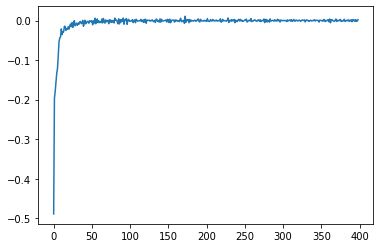

In [277]:
import matplotlib.pyplot as plt
plt.plot(j)

def convergencia(s,neg=True):
    j=[s[i]-s[i-1] for i in range(1,len(s))]
    p=3
    for n,i in enumerate(j):
        if (i>0) ==neg:
            p-=1
        else:
            p=3
            
        if p<0:
            return(n)
        
print(convergencia(teacher_dict['MobileNet']['train/acc'], neg=False))

In [ ]:
field='delta_test'
chart=alt.Chart(source,title="Diferencia de accuracy en entrenamiento con respecto a Resnet101.").mark_point(size=150).encode(
    shape=alt.Shape('layer:O',legend=alt.Legend(title="Bloque"), scale=alt.Scale(scheme='darkgreen')),
    y=alt.Y("delta_test", type='quantitative',title="Delta accuracy.",scale=alt.Scale(zero=False,base=10,type='linear')),
    #column='distillation:O',
    x=alt.X('feat_dist', title="Destilacion de mapa de caracteristicas"),
    color=alt.Fill('student', legend=alt.Legend(title="Modelo")),
    fill=alt.Color('layer:O', legend=alt.Legend(title="Bloque"), scale=alt.Scale(scheme='darkgreen')),
)

bar=alt.Chart(bar_source).mark_rule(opacity=0.9).encode(
                    y=field,
                    color=alt.Color('model', legend=alt.Legend(title="Modelo")),
                    stroke=alt.Stroke('model', legend=alt.Legend(title="Modelo en Cross Entropy")),
                    size=alt.value(2))
d=bar+chart
d.properties(width=600,height=600).configure_axis(titleFontSize=12).configure_title(fontSize=15).interactive()


## Graficos GAN / VAE
Tabla teachers, (mejores, peores, media) en KD y con feats

2- Barras con test_acc,*feats(layer), raya en logit (t8), en grid ([kd] [mobilenet,resnet])
3- Barras con test_acc/train_acc*feats(layer), raya en logit (t8), en grid ([kd] [mobilenet,resnet])
4- majamama tiempo de convergencia, acc (epochs y tiempo)

## Graficos Noise
Tabla teachers, (mejores, peores, media) en KD y con feats

2- Barras con test_acc,*feats(layer), raya en logit (t8), en grid ([kd] [mobilenet,resnet])
3- Barras con test_acc/train_acc*feats(layer), raya en logit (t8), en grid ([kd] [mobilenet,resnet])
4- majamama tiempo de convergencia, acc (epochs y tiempo)

In [466]:
def noise_load():
    s1=normal_whole_source('KD')
    #s1=s1[s1['feat_dist']!='nst_poly']
    s2=data['students']['feat']['noise']
    s3=data['students']['kd']['noise']
    source=pd.concat([s1[s1['feat_dist']!='nst_poly'],s2,s3])
    

    return source
source=noise_load()

In [467]:
import pandas as pd

In [348]:
source=pd.concat([data['students']['feat']['noise'],data['students']['kd']['noise']])
source['noise']=[float(i.split(',')[1]) for i in source['transform']]
source

,test_acc,test_teacher/acc,test_loss,test_eval,train_acc,train_teacher/acc,train_loss,train_eval,student,last_layer,layer,transform,dataset,temp,log_dist,feat_dist,delta_test,test/train,noise
0,87.16,93.94,0.019017,1.077897,88.150,90.648,0.008877,0.831166,MobileNet,"KD,T-8",0,"noise,0.1","cifar10,",8,KD,att_max,-6.78,0.988769,0.1
1,87.61,93.94,0.018349,1.028444,88.272,90.654,0.008999,0.816178,MobileNet,"KD,T-8",1,"noise,0.1","cifar10,",8,KD,att_max,-6.33,0.992500,0.1
2,87.10,93.94,0.019883,1.067656,88.142,90.630,0.009189,0.838657,MobileNet,"KD,T-8",2,"noise,0.1","cifar10,",8,KD,att_max,-6.84,0.988178,0.1
3,87.46,93.94,0.023735,1.049526,88.240,90.682,0.012695,0.822420,MobileNet,"KD,T-8",3,"noise,0.1","cifar10,",8,KD,att_max,-6.48,0.991160,0.1
4,86.76,93.94,0.020558,1.102234,88.202,90.622,0.008982,0.822932,MobileNet,"KD,T-8",0,"noise,0.1","cifar10,",8,KD,att_mean,-7.18,0.983651,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,13.99,93.94,0.208867,14.103969,10.000,10.006,0.000227,39.673044,ResNet18,NaN,Ninguna,"noise,0.8","cifar10,",8,KD,Ninguna,-79.95,1.399000,0.8
16,10.00,93.94,0.314663,25.543369,10.002,10.014,0.000340,39.598546,MobileNet,NaN,Ninguna,"noise,0.9","cifar10,",8,KD,Ninguna,-83.94,0.999800,0.9
17,14.17,93.94,0.192857,12.079886,10.002,10.008,0.000216,39.663110,ResNet18,NaN,Ninguna,"noise,0.9","cifar10,",8,KD,Ninguna,-79.77,1.416717,0.9
18,10.00,93.94,0.385345,32.944604,10.016,10.016,0.000366,38.649472,MobileNet,NaN,Ninguna,"noise,1.0","cifar10,",8,KD,Ninguna,-83.94,0.998403,1.0


In [476]:
def noise_plot(source=source,
               title="Diferencia con ResNet101 contra ruido",
               y='delta_test',
               color='feat_dist',
               shape='layer',
               student='ResNet18'):


        sou=source[source['student']==student]

        selection = alt.selection_multi(fields=[color], bind='legend')


        base = alt.Chart(sou).mark_line().encode(
            x='noise:Q',
            y='%s:Q'%y,

            color=alt.Color('%s:N'%color, legend=alt.Legend(title=global_titles[color]), scale=alt.Scale(scheme='spectral')),
            shape=alt.Shape('%s:N'%shape, legend=alt.Legend(title=global_titles[shape])),
            strokeDash=alt.Stroke('%s:N'%shape, legend=alt.Legend(title=global_titles[shape])),
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2))

        ).add_selection(
            selection
        ).properties(
            width=600,
            height=600
        )


        line = alt.Chart(sou).mark_line().encode(
            x='noise',
            y='mean(%s)'%y,
            color=alt.Color('%s:N'%color, legend=alt.Legend(title=global_titles[color]), scale=alt.Scale(scheme='spectral')),
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
            #opacity=alt.value(0.5)
        )

        band = alt.Chart(sou).mark_errorband(extent='ci').encode(
            x=alt.X('noise', title=global_titles['noise']),
            y=alt.Y('%s'%y, title=global_titles[y]),
            color=alt.Color('%s:N'%color, legend=alt.Legend(title=global_titles[color]), scale=alt.Scale(scheme='spectral')),
            opacity=alt.condition(selection, alt.value(0.4), alt.value(0.05))
        )

        w=base+ band + line
        w.properties(
            width=600,
            height=600
        )
        return w
noise_plot()

alt.LayerChart(...)